# **Script to calculate detection rate for VSAM, Ft-SAM, PlantSeg**

*   Input: Mask pickle files
*   Output: Detection rate

In this script we calculate the detection rate using the saved pickle files of detected masks from VSAM, Ft-SAM and PlantSeg. The results from PlantSeg is produced locally following the instructions given in https://github.com/hci-unihd/plant-seg

## VSAM/Ft-SAM detection rate

In [3]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageStat
from skimage import io #, util, color
import sys
import cv2
import pickle
import ipywidgets as widgets
from IPython.display import display
import random

In [ ]:
!pip install session-info
import session_info
session_info.show()

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8027 sha256=298cdbfb420b51dfbc9c6246797b4521a5ef3dd4f37582fb7b398a1486e0dc96
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


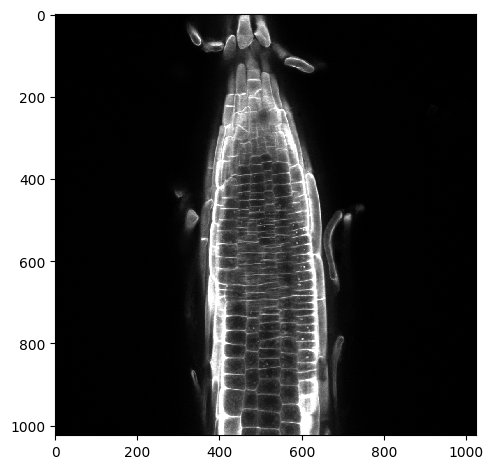

In [4]:
# Visualize input image
image = io.imread("/content/drive/MyDrive/SAMPLS/input_images_and_segmentation_results/image_3/input_img_3.tif")
if image.shape[2] > 3:
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
io.imshow(image)

In [ ]:
#Load image masks from VSAM, Ft-SAM, PlantSeg
with open(f"/content/drive/MyDrive/sanchari_masks_pkl_sam/masks20.pkl", 'rb') as file:
    total_masks = pickle.load(file)

In [ ]:
# Mask Selection Tool
# Load the masks
masks = total_masks
# Initialize variables
selected_masks = [False] * len(masks)

# Create a grid layout to display masks and checkboxes
grid_layout = widgets.GridspecLayout(len(masks), 3, width='60%')
mask_widgets = []

# Function to toggle mask selection
def toggle_selection(change, index):
    selected_masks[index] = not selected_masks[index]

# Function to display masks and checkboxes
def display_masks():
    for i, mask in enumerate(masks):
        checkbox = widgets.Checkbox(value=False, description='Include')
        checkbox.observe(lambda change, index=i: toggle_selection(change, index), names='value')

        mask_widgets.append(widgets.Image(value=image_to_byte_array(mask), format="png"))
        mask_widgets[-1].layout.height = '200px'

        grid_layout[i, 0] = checkbox
        grid_layout[i, 1] = mask_widgets[-1]

# Convert NumPy array to byte array for display
def image_to_byte_array(image):
    from io import BytesIO
    img_byte_array = BytesIO()
    plt.imsave(img_byte_array, image, format='png')
    return img_byte_array.getvalue()

# Display the masks and checkboxes
display_masks()

# Create a button to apply the selection
apply_button = widgets.Button(description="Apply Selection")
output = widgets.Output()

# Function to apply the selection and create new lists
def apply_selection(_):
    global selected_masks
    global unselected_masks

    # Create new lists for selected and unselected masks
    selected_mask_list = [mask for mask, selected in zip(masks, selected_masks) if not selected]
    unselected_mask_list = [mask for mask, selected in zip(masks, selected_masks) if selected]

    # Update mask_list and selected_masks
    selected_masks = selected_mask_list
    # unselected_masks = [False] * len(masks)
    unselected_masks = unselected_mask_list

    with output:
        print("Selected images discarded.")
        print("Unselected images included.")


# Bind button action
apply_button.on_click(apply_selection)


# Display the checkboxes, images, and the Apply button
display(widgets.VBox([grid_layout, apply_button, output]))


In [ ]:
import numpy as np

# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((masks[0].shape[0], masks[0].shape[1]), dtype=np.uint8)

# Iterate through the individual object masks and combine them
for object_mask in selected_masks:
    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)

In [ ]:
# Masks that are represent correct cell segmentation
len(selected_masks)

175

In [ ]:
# Masks that are represent incorrect cell segmentation
len(unselected_masks)

0

In [ ]:
# Update the pickle file with list of masks representing correct cell segmentation
with open(f"/content/drive/MyDrive/sanchari_masks_pkl/masks20.pkl", 'rb') as file:
    total_masks = pickle.load(file)

## PlantSeg - detection rate

<ipython-input-27-da0d78faa3c4>:21: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 113601 to uint16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img[i][j] = np.uint16(newColor)
<ipython-input-27-da0d78faa3c4>:24: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 113601 to uint16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img[i][j] = np.uint16(colorMatrix[g])
<ipython-input-27-da0d78faa3c4>:21: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of 326501 to uint16 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the des

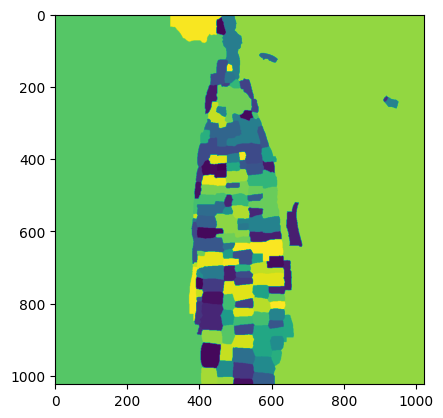

In [ ]:
# Importing preictions from PlantSeg
image2 = io.imread("/content/12_stack_predictions_multicut.tiff") #segmentation result from PlantSeg
colorMatrix = {}
colorList = []
colors = range(1, 500000, 100) # 25, 50, 100
oldColor = 0
seg_img = []
for img in image2:
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):

      g = img[i][j]
      if g == 1:
        img[i][j] = 255
      elif g not in colorMatrix:
        newColor = colors[random.randint(0, len(colors) - 1)]
        while(newColor in colorList or (newColor < (oldColor + 100) and newColor > (oldColor - 250))):
          newColor = colors[random.randint(0, len(colors) - 1)] + 100
        colorList.append(newColor)
        colorMatrix[g] = newColor
        img[i][j] = np.uint16(newColor)
        oldColor = newColor
      else:
        img[i][j] = np.uint16(colorMatrix[g])
        oldColor = colorMatrix[g]
  seg_img.append(img)
plt.imshow(seg_img[7])

In [ ]:
# Save PlantSeg segmented image as .png
io.imsave("san_img.png",seg_img[7])

In [ ]:
# Assign unique labels to each cell segmentation

unique_labels = np.unique(image2[0])
masks2 = []
for label in unique_labels:
    # Create a mask for the current label
    mask1 = (image2[0] == label).astype(np.uint8)
    masks2.append(mask1)


In [ ]:
# Mask Selection tool for filtering masks by PlantSeg
# Initialize variables
selected_masks = [False] * len(masks2)

# Create a grid layout to display masks and checkboxes
grid_layout = widgets.GridspecLayout(len(masks2), 3, width='60%')
mask_widgets = []

# Function to toggle mask selection
def toggle_selection(change, index):
    selected_masks[index] = not selected_masks[index]

# Function to display masks and checkboxes
def display_masks():
    for i, mask in enumerate(masks2):
        checkbox = widgets.Checkbox(value=False, description='Include')
        checkbox.observe(lambda change, index=i: toggle_selection(change, index), names='value')

        mask_widgets.append(widgets.Image(value=image_to_byte_array(mask), format="png"))
        mask_widgets[-1].layout.height = '200px'

        grid_layout[i, 0] = checkbox
        grid_layout[i, 1] = mask_widgets[-1]

# Convert NumPy array to byte array for display
def image_to_byte_array(image):
    from io import BytesIO
    img_byte_array = BytesIO()
    plt.imsave(img_byte_array, image, format='png')
    return img_byte_array.getvalue()

# Display the masks and checkboxes
display_masks()

# Create a button to apply the selection
apply_button = widgets.Button(description="Apply Selection")
output = widgets.Output()

# Function to apply the selection and create new lists
def apply_selection(_):
    global selected_masks
    global unselected_masks

    # Create new lists for selected and unselected masks
    selected_mask_list = [mask for mask, selected in zip(masks2, selected_masks) if not selected]
    unselected_mask_list = [mask for mask, selected in zip(masks2, selected_masks) if selected]

    # Update mask_list and selected_masks
    selected_masks = selected_mask_list
    # unselected_masks = [False] * len(masks)
    unselected_masks = unselected_mask_list

    with output:
        print("Selected images discarded.")
        print("Unselected images included.")


# Bind button action
apply_button.on_click(apply_selection)


# Display the checkboxes, images, and the Apply button
display(widgets.VBox([grid_layout, apply_button, output]))


In [ ]:
# Correct segmentation
len(selected_masks)

10

In [ ]:
# Incorrect segmentation
len(unselected_masks)

16

In [ ]:
import numpy as np

empty_mask = np.zeros((masks2[0].shape[0], masks2[0].shape[1]), dtype=np.uint8)

for object_mask in selected_masks:
    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)

In [ ]:
# Update list of masks with filtered masks
with open(f"/content/drive/MyDrive/sanchari_ps_masks/masks12.pkl", 'wb') as file:
  pickle.dump(selected_masks, file)

## Visualizing Segmentation results from VSAM, Ft-SAM, PlantSeg

In [ ]:
with open(f"/content/drive/MyDrive/sanchari_sam_resized/masks12.pkl", 'rb') as file: # Image ID starts with 1
    masks = pickle.load(file)

<ipython-input-17-b76a54759cc7>:13: UserWarning: vsam_img1.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave("vsam_img1.png", empty_mask)


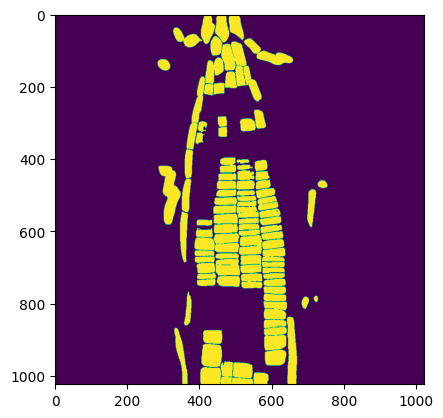

In [ ]:
import numpy as np

# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((masks[0].shape[0], masks[0].shape[1]), dtype=np.uint8)

# Iterate through the 10 individual object masks and combine them
for object_mask in masks:
    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)
io.imsave("vsam_img1.png", empty_mask)

In [ ]:
with open(f"/content/drive/MyDrive/finetune_sanchari_masks/masks11.pkl", 'rb') as file: # Image ID starts with 0
    masks = pickle.load(file)

<ipython-input-31-29109ab1c8a1>:13: UserWarning: ft_sam_img2.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave("ft_sam_img2.png", empty_mask)


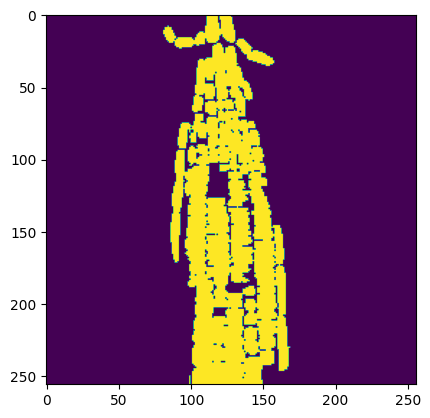

In [ ]:
import numpy as np

# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((masks[0].shape[0], masks[0].shape[1]), dtype=np.uint8)

# Iterate through the 10 individual object masks and combine them
for object_mask in masks:
    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)
io.imsave("ft_sam_img2.png", empty_mask)

In [ ]:
with open(f"/content/drive/MyDrive/sanchari_ps_masks/masks12.pkl", 'rb') as file: # Image ID starts 1
    masks = pickle.load(file)

<ipython-input-25-4958b812c193>:13: UserWarning: ft_sam_img1.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave("ft_sam_img1.png", empty_mask)


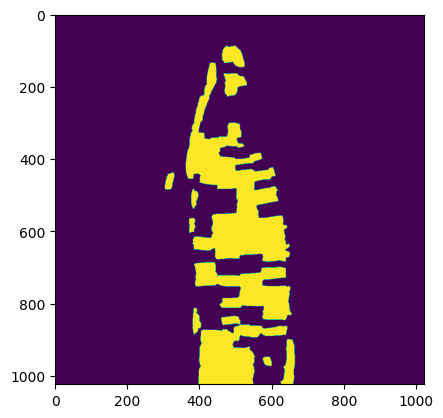

In [ ]:
import numpy as np

# Assuming you have a list of object masks (masks) and an image size (image_height, image_width)

# Initialize an empty mask with the same dimensions as your image
empty_mask = np.zeros((masks[0].shape[0], masks[0].shape[1]), dtype=np.uint8)

# Iterate through the 10 individual object masks and combine them
for object_mask in masks:
    empty_mask = np.logical_or(empty_mask, object_mask)

plt.imshow(empty_mask)
io.imsave("san_ps_mask.png", empty_mask)